# UFO Classification

TenantBase brokers have started to go missing after tours, causing company stakeholders great concern. Interestingly, the principal investigator from LAPD noticed that each of the missing person reports coincide with UFO sightings (per the National UFO Reporting Center). To learn how to spot this concerning phenomenon, the company would like to automate a UFO shape-classifier.

## Set-Up

Before this dataset was imported into Python, it was validated in Excel. By checking if/where incorrect data types appeared in any given column, it became clear that many standard database formatting "rules" were violated. For example, first normal form (1NF) was violated since many cells had more than one value per attribute/column; to fix this, cells were split and shifted over to fit expected dimensions and column type-casting. Additionally, since a substantial number of target values were missing, it was helpful to read the comments and add data to the 'shape' column as appropriate (if shape wasn't clearly stated in the comment, it was declared 'unknown').

In [1]:
%autosave 120

Autosaving every 120 seconds


### Load and Preview Data

In [2]:
import pandas as pd
data = pd.read_csv (r'C:\Users\Amelia Helland\Desktop\Git\tenantbase-challenge\complete_data.csv', low_memory=False)
df = pd.DataFrame(data)
df[29:33]

datetime incident date   time                  city state country  \
29   10/10/1979 0:00    1979-10-10   0:00          poughkeepsie    ny      us   
30  10/10/1979 22:00    1979-10-10  22:00  saddle lake (canada)    ab     NaN   
31  10/10/1979 22:00    1979-10-10  22:00             san diego    ca      us   
32  10/10/1979 22:00    1979-10-10  22:00              security    co      us   

       shape duration (seconds) duration (hours/min)  \
29   chevron                900           15 minutes   
30  triangle                270     4.5 or more min.   
31      oval                180            3 minutes   
32   unknown               1800              30mins.   

                                             comments date posted    latitude  \
29  1/4 moon-like&#44  its &#39chord&#39 or flat s...  2005-04-16  41.7002778   
30  Lights far above&#44  that glance; then flee f...  2005-01-19   53.970571   
31               My 2nd UFO sighting&#44 October 1979  2001-08-05  32.7152778   
32  very low clouds all different colors&#44search...  1999-01-28  38.7583333   

     longitude  
29  -73.921389  
30 -111.689885  
31 -117.156389  
32 -104.742500

There are NaN/NA values throughout the dataset. Duration (hours/min) column is inconsistently formatted, as are city/state entries. Commentary needs parsing (important because this attribute will be considered the feature of primary interest for initial research purposes). 

### Clean Data

In [3]:
df1 = df.replace(['&#\d{2}', '&quot'], ['',''], regex=True)
df1[['comments']][29:33]

comments
29  1/4 moon-like  its chord or flat side parallel...
30  Lights far above  that glance; then flee from ...
31                   My 2nd UFO sighting October 1979
32  very low clouds all different colorssearch lig...

Data looks much more clean, but there are still NaN/NA values. It will be good to get an idea of how many per column.

In [4]:
percent_missing = df1.isnull().sum() * 100 / len(df1)
missing_value_df = pd.DataFrame({'column_name': df1.columns,
                                 'percent_missing': percent_missing})
missing_value_df

column_name  percent_missing
datetime                          datetime         0.000000
incident date                incident date         0.000000
time                                  time         0.000000
city                                  city         0.217169
state                                state         8.457202
country                            country        14.130594
shape                                shape         0.097895
duration (seconds)      duration (seconds)         0.002250
duration (hours/min)  duration (hours/min)         3.550089
comments                          comments         0.049510
date posted                    date posted         0.000000
latitude                          latitude         0.096769
longitude                        longitude         0.000000

Fairly complete data. Should be safe to drop NaN/NA values.

In [21]:
df1 = df1.dropna()

Now to get some basic familiarity with outcome variable.

In [22]:
table1 = pd.crosstab(index = df1["shape"], columns = "count")
table1

col_0      count
shape           
alien         74
changing    6322
chevron      870
cigar       1799
circle      6730
cone         282
crescent       3
cross        214
cylinder    1122
diamond     1025
disc          29
dome           1
egg          651
fireball    5532
flare          3
flash       1205
formation   2239
invisible      3
light      14888
other       4992
oval        3321
rectangle   1157
round         19
saucer         4
sphere      4703
streak        14
teardrop     639
triangle    7112
unknown     6206
unrelated      3

Too many levels (and typos). Aggregation will help. Shapes observed less than or equal to 3 times will be put into 'other' category.

In [23]:
omit = {'lights', 'flares', 'aliens', 'changed', 'ciger', 'circles', 'cluster', 'disk', 'fireballs', 'unknwon', 'saucers', 'spheres'}
replace = {'light', 'flare', 'alien', 'changing', 'cigar', 'circle', 'formation','disc', 'fireball','unknown', 'saucer','sphere'}
df1 = df.replace(omit, replace)
df1 = df1.replace('lunknown', 'unknown')
df1 = df1.replace('un', 'unknown')
df1 = df1.replace(['dsic','delta'], ['disc','triangle'])
df1 = df1.replace(['L','V','Y','satellite', 'kidneybean', 'clamshell'], ['formation','formation','formation','other', 'other', 'other'])
df1 = df1.replace(['eggplant', 'ellipse', 'ring'], ['round', 'round', 'round'])
df1 = df1.replace(['flat','hexagon','square','parachute','pyramid','rocket','torpedo','trapezoid'], ['other', 'other', 'other', 'other', 'other', 'other', 'other', 'other'])

Check shapes again...

In [24]:
table2 =  pd.crosstab(index = df1["shape"], columns = "count")
print('There are', len(table2), 'shapes to classify.')
table2

There are 30 shapes to classify.


col_0      count
shape           
alien        110
changing    8142
chevron     1008
cigar       2265
circle      8486
cone         372
crescent       4
cross        266
cylinder    1390
diamond     1311
disc          64
dome           4
egg          852
fireball    6640
flare          6
flash       1494
formation   2756
invisible      4
light      18159
other       6304
oval        4138
rectangle   1426
round         31
saucer         7
sphere      5795
streak        21
teardrop     822
triangle    8567
unknown     8315
unrelated     25

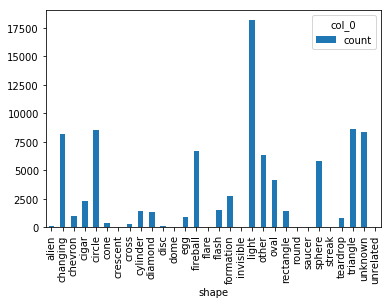

In [12]:
%matplotlib inline
shapes = pd.crosstab(index = df1["shape"],  # Make a crosstab
                              columns="count") # Name the count column      
shapes.plot.bar()

Most commonly reported shape is light, followed by circle and triangle. It may be helpful to use this info as prior distribution data in the classifier (if certain UFO shapes are more likely to be seen/reported, that factor should be taken into consideration). Comments will be transformed into word vectors so that underlying features can be extracted for improved classification rates.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

df1 = df1.dropna()
features = tfidf.fit_transform(df1.comments).toarray()
labels = df1['shape']
features.shape

(71162, 20928)

Each of 71162 comments is represented by 20928 features, representing the tf-idf score for different unigrams and bigrams.

In [20]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for shape, category_id in sorted(df1.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(shape))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'city':
  . Most correlated unigrams:
. fernando
. fenton
  . Most correlated bigrams:
. field vision
. zooms away
# 'comments':
  . Most correlated unigrams:
. fireball
. changing
  . Most correlated bigrams:
. shaped object
. bright light
# 'country':
  . Most correlated unigrams:
. fernando
. fenton
  . Most correlated bigrams:
. field vision
. zooms away
# 'date posted':
  . Most correlated unigrams:
. fernando
. fenton
  . Most correlated bigrams:
. field vision
. zooms away
# 'datetime':
  . Most correlated unigrams:
. fernando
. fenton
  . Most correlated bigrams:
. field vision
. zooms away
# 'duration (hours/min)':
  . Most correlated unigrams:
. plano
. visitation
  . Most correlated bigrams:
. orange blinking
. allen 44
# 'duration (seconds)':
  . Most correlated unigrams:
. fernando
. fenton
  . Most correlated bigrams:
. field vision
. zooms away
# 'incident date':
  . Most correlated unigrams:
. fernando
. fenton
  . Most correlated bigrams:
. field vision
. zooms away


Text analysis shows that Fernando and Fenton seem to be the two most highly correlated unigrams (single words) reported across data attributes. For most of the data attributes, the most highly correlated bigram (word pair) is (field vision, zooms away). It may be helpful to see if there are trends in reports (or reported shapes) over time.

### Split into training, validation, testing datasets

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df1['comments'], df1['shape'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

Train model (using Multinomial Naive Bayes as benchmark).

In [33]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [34]:
predictions = clf.predict(count_vect.transform(X_test))

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predictions)
error_rate = 1 - accuracy
error_rate

0.6747793828340172

Error rate is rather high. Will test other methods to see if they perform better.

In [51]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


MemoryError: 

In [47]:
cv_df.groupby('model_name').accuracy.mean()

KeyError: 'model_name'

As expected, the Random Forest Classifier performed worst, and the Multinomial Naive Bayes model failed to outperform the other models in consideration. Unsurprisingly, the Logistic Regression model had the highest accuracy; thus, it is preferred and will be used as the final training/testing model. This result is not very surprising because logistic regression algorithms tend to over-fit data. For the sake of generalizability, it may be necessary to default to the next-best classification method: LinearSVC. Although this can be determined mathematically, by calculating whether p≫nπ(1−π) for π=Prob(Y=1), it should be interesting to see what the Logistic Regression testing results show. If accuracy noticeably decreases in the testing phase, the Logistic Regression training model is likely biased (i.e., describes sample data so closely that it misses the trend).

In [48]:
model = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df1.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=X_test, yticklabels=y_test)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show() #REALLY ANNOYED THAT THIS ISN'T WORKING! 

MemoryError: 

For π=Prob(Y=1)=0.48259, n=71162, p=20928,
71162*0.48259*(1-0.48259) = 17768.9.
Thus, since 20928 > 17768.9, it is reasonable to say the Logistic Regression model is not generalizable, and the LinearSVC model should be preferred. 

In [49]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df1.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=X_test, yticklabels=y_test)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

MemoryError: 

# Summary

LinearSVC was determined to be the most appropriate model for classifying UFO shapes, because it produced the highest accuracy measure without overfitting the data.

This dataset is highly limited in terms of how useful the reported comments are when classifying UFO shapes. Comments were cut off after the first 100 characters, so a lot of potentially important context was missing right off the bat (too many people ramble at the start of their commentary). Of course, there is also natural subjectivity in how people describe things; this substantially increases the noise to signal ratio in classification, making it difficult for models to perform well.

There are many ways in which future studies could be improved. First and foremost, since the predictor input is so limited (i.e. subjective, abridged), it is highly advisable that researchers determine and incorporate prior distributions of shapes reported in the training dataset. By leveraging prior information, one may obtain the Maximum a Posteriori (MAP) estimation for the set of probability distribution parameters; this could improve classification performance because it mathematically finds the most likely shape/class-distributions for a given set of evidence. If it turns out that there is some flexibility with regards to how prior beliefs are expressed, it may be necessary to consider a conjugate prior distribution (so as to find a normalization constant which facilitates successful integration of the probability of observing the set of evidence); in this case, it would be helpful to consider applying Monte Carlo integration in Bayesian Estimation.

It may also be helpful to perform Principle Component Analysis on word vectors, so that a cluster analysis can be performed. Especially since this data is all labeled, it would be possible to determine if clusters have any practical meaning (e.g., if there is a high degree of separation between groups 1 and 2; and, if most of the shapes in group 1 are called 'fireball', while most in group 2 are called 'circle'; it may be possible to compare/classify vectors of new/test data by assessing the sensitivity and specificity of different probability threshholds).

Of course, it may also be helpful (or interesting) to visualize this data per the provided geocoordinates. Unfortunately, since the latitude/longitude data could not be verified with real city locations, it will be necessary to postpone this aspect of data visualization until an outside source or system is obtained for reference. Future analyses may show different areas having higher levels of UFO sightings or certain UFO shapes; if this is ever determined to be true, it might be helpful to incorporate this feature into the classification models of interest. 

# Business Recommendations

Although this UFO shape classification project has much room for improvement, and the premise offers a vast and educational problem space, it would behoove TenantBase to consider re-framing their question of interest. This project cannot illuminate much helpful information about the pattern of primary concern (i.e., company brokers going missing), because there is little-to-no provable relationship between UFO shape and details about if/when/where contact was made. To get actionable insights that help directly solve the business problem, TenantBase should focus on studying outlier cases where 'alien' was the reported sighting.

In cases of alien encounters, comments describe direct contact with the extraterrestrial entity/entities; this is much more concerning than that which was reported for most other shapes (most citations described distant sightings or aural disturbances, which are far less threatening). Plus, using the data in this capacity will enable more specific geospatial understanding of incidents. Realistically speaking, TenantBase does not have the funds to go investigate thousands of locations where UFOs were sighted/sensed; however, it may be possible for TenantBase to sponsor an investigation of the most severe incidents. Going straight for the aliens is most likely to save the company time (which gets brokers back to their families/coworkers/clients sooner) and money (so the company can get back to focusing on expansion, marketing, etc.).
